In [7]:
import mysql.connector
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import json
from scipy import stats
import os
import _pickle as cPickle
import warnings
warnings.filterwarnings('ignore')

os.chdir("C:/Users/Nicholas Bonaker/PycharmProjects/NomonWeb/")

def save_pvalues(dict):
    pickle_path = 'D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/pvalues.pkl'
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as fp:
            pvalue_dict = cPickle.load(fp)
    else:
        pvalue_dict = {}
        
    
    for key in dict.keys():
        pvalue_dict[key] = dict[key]
     
    with open(pickle_path, 'wb') as fp:
        cPickle.dump(pvalue_dict, fp)
        
def test_significance(nomon_data, rowcol_data):
    shapiro_stat, shapiro_p = stats.shapiro(nomon_data - rowcol_data)
    
    if shapiro_p <= 0.05:
        print("Normality Assumption Violated. Running Wilcoxin", shapiro_stat, shapiro_p)

        Z_stat, p_value = stats.wilcoxon(nomon_data-rowcol_data)
        r = Z_stat / (len(nomon_data)*(len(nomon_data)+1)/2)
        return {"Z": Z_stat, "r": r, "p": p_value}
    else:
        print("Running Dependant T test")
        t_stat, p_value = stats.ttest_rel(nomon_data, rowcol_data)
        df = len(nomon_data)-1
        r = np.sqrt(t_stat**2/(t_stat**2+df))
        return {"t": t_stat, "r": r, "p": p_value}
    
def calculate_quantiles(plot_df, metric):
    lower_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.25)
    lower_quantiles = lower_quantiles.reset_index()
    nomon_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "RCS"][metric].values
    
    upper_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.75)
    upper_quantiles = upper_quantiles.reset_index()
    nomon_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "RCS"][metric].values
    
    return {"lower": {"nomon": nomon_lower_quantiles, "rowcol": rowcol_lower_quantiles},
            "upper": {"nomon": nomon_upper_quantiles, "rowcol": rowcol_upper_quantiles}}      
    
    
def r(x, y):
    return x != y


def calc_MSD(a, b):
    
    if a[-1] == "_" or a[-1] == " ":
        a = a[:-1]
    if b[-1] == "_" or b[-1] == " ":
        b = b[:-1]

    a = np.array(list(a))
    b = np.array(list(b))

    D = np.zeros((a.size, b.size))

    for i in range(a.size):
        D[i, 0] = i

    for j in range(b.size):
        D[0, j] = j

    for i in range(a.size):
        for j in range(b.size):
            D[i, j] = min(D[i-1, j]+1, D[i, j-1]+1, D[i-1, j-1] + r(a[i], b[j]))
    return D[-1, -1], D[-1, -1] / b.size

time_rotate_li = [4]
for i in range(21):
    time_rotate_li += [4*np.exp((-i)/10)]
    
scan_delay_li = [2]
for i in range(21):
    scan_delay_li += [2*np.exp((-i)/14)]

extra_delay_li = [2]
for k in range(11):
    extra_delay_li += [0.2*(10-k)]


mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="MIuserDB"
)
mycursor = mydb.cursor()

user_df = pd.read_sql('SELECT id, nomon_practice, rowcol_practice, nomon_symbol, rowcol_symbol, nomon_text, rowcol_text, dates FROM study_info', con=mydb)

users=[85]
user_df = user_df[user_df["id"].isin(users)].drop_duplicates()
user_df.dates = user_df.dates.apply(lambda x: json.loads(x)[-1])

user_df

,id,nomon_practice,rowcol_practice,nomon_symbol,rowcol_symbol,nomon_text,rowcol_text,dates
13,85,8,2,5,4,5,4,2022-5-3


In [10]:
# with open("D:/Users/nickb/PycharmProjectsD/NomonWeb/v1.1.2/resources/phrases_oov.json", 'rb') as fp:
#     oov_phrases = json.load(fp)

with open("phrases/phrases_oov.json", 'rb') as fp:
    oov_phrases = json.load(fp)

entry_df = pd.DataFrame(columns=["id", "Session Number", "Keyboard", "phrase_num", "typed_len", "num_click", "num_sel", 
                                 "num_corr", "start", "end", "Final Error Rate", "Time Rotate", 
                                 "Scan Delay", "Extra Delay", "is_oov"])

users = user_df.id.values
software_names = {"nomon": "Nomon", "rowcol": "RCS"}

# Claire Picture Selection
# data_tables = [               
               # ["nomon_session_10_user_85", "nomon", "picture"],
               # ["nomon_session_11_user_85", "nomon", "picture"],
               # ["nomon_session_12_user_85", "nomon", "picture"],
               # 
               # 
               # ["rowcol_session_3_user_85", "rowcol", "picture"],
               # ["rowcol_session_4_user_85", "rowcol", "picture"],
               # ["rowcol_session_5_user_85", "rowcol", "picture"],]

data_tables = [["nomon_session_1_user_85", "nomon", "picture"],
               ["nomon_session_2_user_85", "nomon", "picture"],
               ["nomon_session_3_user_85", "nomon", "picture"],
               ["nomon_session_4_user_85", "nomon", "picture"],
               ["nomon_session_5_user_85", "nomon", "picture"],
               ["nomon_session_6_user_85", "nomon", "picture"],
               ["nomon_session_7_user_85", "nomon", "picture"],
               ["nomon_session_8_user_85", "nomon", "picture"],
               ["nomon_session_9_user_85", "nomon", "picture"],

               ["nomon_session_10_user_85", "nomon", "picture"],
               ["nomon_session_11_user_85", "nomon", "picture"],
               ["nomon_session_12_user_85", "nomon", "picture"],
               ["nomon_session_14_user_85", "nomon", "text"],
               
               ["nomon_session_15_user_85", "nomon", "text"],
               ["nomon_session_16_user_85", "nomon", "text"],
               ["nomon_session_17_user_85", "nomon", "text"],
               ["nomon_session_18_user_85", "nomon", "text"]
]

# Claire Text Entry
# data_tables = [["nomon_session_15_user_85", "nomon", "text"],
#                ["nomon_session_16_user_85", "nomon", "text"],
# 
#                ["rowcol_session_7_user_85", "rowcol", "text"],
#                ["rowcol_session_8_user_85", "rowcol", "text"],
#                ["rowcol_session_9_user_85", "rowcol", "text"],
#                ["rowcol_session_10_user_85", "rowcol", "text"],]




In [3]:
user=85


click_df = pd.DataFrame(columns=["Session", "Phrase", "Clock Speed", "Click Time","Click Load", "Task", "Final Error"])

session_num = 0
for data_table, software, style in data_tables:
    session_num += 1

    mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
    phrase_nums = np.array(mycursor.fetchall()).T[0]
    
    for phrase_num in phrase_nums:
        
        mycursor.execute("SELECT typed_text FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                         " ORDER BY timestamp DESC LIMIT 1")
        typed_text = mycursor.fetchall()[0][0]
        
        mycursor.execute("SELECT phrase FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+ " LIMIT 1")
        phrase_text = mycursor.fetchall()[0][0]
        
        
        
        if style == "picture":
            
            typed_text = typed_text.replace("..", "")
            
            typed_text_arr=typed_text.split(" ")[:-1]
            typed_len = len(typed_text_arr)
            if typed_len < 3:
                continue
            elif typed_len < 5:
                phrase_text_arr=phrase_text.split(" ")[:typed_len]
            else:
                phrase_text_arr=phrase_text.split(" ")[:-1]
            
            uncorrected_error = calc_MSD(typed_text_arr, phrase_text_arr)[1]
            is_oov = False
            
        else:
            typed_text = typed_text.replace(".", "")
            typed_text = typed_text.replace("_", "")
        
            typed_len = len(typed_text)
            if typed_len < 10:
                continue
            
            uncorrected_error = calc_MSD(typed_text, phrase_text)[1]
            is_oov = ["IV", "OOV"][phrase_text in oov_phrases]
        
        if typed_len == 0:
            continue
        
        
        mycursor.execute("SELECT rel_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                             " ORDER BY timestamp ASC")
        click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
        num_clicks = sum([len(click_arr) for click_arr in click_times])
        
        while len(click_times[0]) == 0:
            click_times = click_times[1:]
        flattened_click_times = [time for selection in click_times for time in selection]
        
        mycursor.execute("SELECT rotate_ind FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
        rotate_ind = mycursor.fetchall()[0][0]
        
        mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num))
        num_selections = mycursor.fetchall()[0][0]
        
        for click_time in flattened_click_times:
            click_data = dict()
            
            click_data["Phrase"] = phrase_num
            click_data["Session"] = session_num
            click_data["Phrase"] = phrase_num
            click_data["Clock Speed"] = time_rotate_li[rotate_ind]
            click_data["Click Time"] = click_time
            click_data["Click Load"] = num_clicks/num_selections
            click_data["Task"] = style
            click_data["Final Error"] = uncorrected_error
        
            click_df = click_df.append(click_data, ignore_index=True)
        
        
        
        
    
    # print(2*np.std(session_click_times), " ", session_time_rotates[-1], " ", session_num)
    

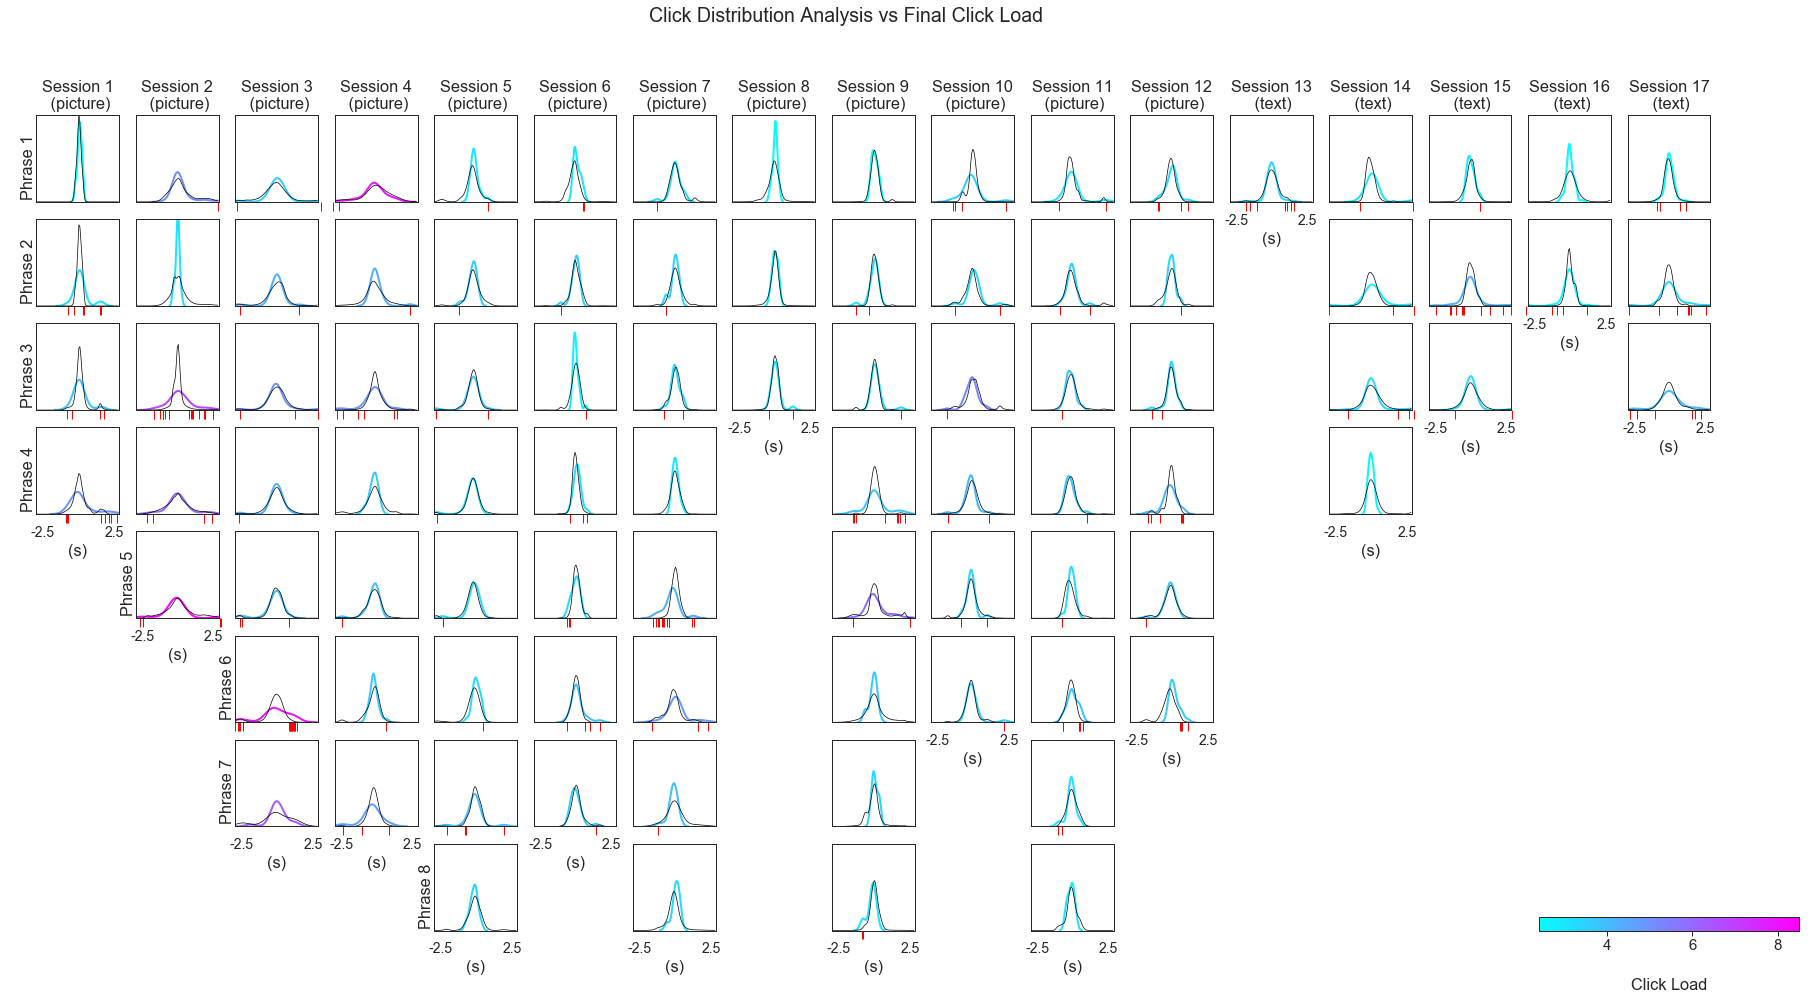

In [13]:
num_rows = int(max(click_df["Session"]))
num_cols = int(max(click_df["Phrase"]))

error_metric = "Click Load"
error_max = max(click_df[error_metric])
error_min = min(click_df[error_metric])

sns.set_context("paper", font_scale=1.7)
sns.set_style("white")
sns.set_palette("tab10")

fig, axes = plt.subplots(num_cols, num_rows,figsize=(30, 15))

# plt.subplots_adjust(left=0.15)
axes = np.array(axes)
cmap = matplotlib.cm.get_cmap('cool')

rows_with_labels = []

cum_click_index=0
kde = KernelDensityEstimation(5.0)

for yin in click_df["Click Time"].to_numpy()[:15]:
    kde.add_point(yin)


for session_num in click_df["Session"].unique():
    session_df = click_df[(click_df["Session"] == session_num)]
    
    num_phrase_in_session = int(max(session_df["Phrase"]))  
    
    for phrase_num in range(1, num_cols+1):
        cur_ax = axes[int(phrase_num)-1, int(session_num)-1]
        phrase_df = session_df[(session_df["Phrase"] == phrase_num)]
        
        
        if len(phrase_df["Click Time"].to_numpy())> 0:
            
            # cur_ax.axvline(0, color="grey", linestyle="--")
            # cur_ax.axvline(np.mean(phrase_df["Click Time"].to_numpy()), color="k")
            

            error = (phrase_df[error_metric].to_numpy()[0]-error_min)/(error_max-error_min)
            rgba = cmap(error)
            # if session_num == 13:
            #     rgba=(0,0,0,1)
            
            sns.distplot(phrase_df["Click Time"], hist=False, color=rgba, kde_kws={"lw": 2}, norm_hist=False, ax=cur_ax)
            
            kde_dens = np.array(kde.dens_li)/np.sum(np.array(kde.dens_li)*5/80)    
            cur_ax.plot(np.arange(-2.5, 2.5, 5/80), kde_dens,
                        color="k", linestyle="-", linewidth=.7)
            
            for yin in phrase_df["Click Time"].to_numpy():
                kde.add_point(yin)
            
            
            cum_kde_dens = np.cumsum(kde_dens)
            cum_kde_dens/=cum_kde_dens[-1]
            
            percentile = 0.05
            lower_percentile = np.arange(-2.5, 2.5, 5/80)[min(np.where(cum_kde_dens > percentile)[0])]
            upper_percentile = np.arange(-2.5, 2.5, 5/80)[min(np.where(cum_kde_dens > 1-percentile)[0])]
            outliers = phrase_df[(phrase_df["Click Time"] < lower_percentile) | (phrase_df["Click Time"] > upper_percentile)]           
            
            if outliers.size > 0:
                sns.rugplot(data=outliers, x="Click Time", height=-.1, color='r', linewidth=1, clip_on=False, ax=cur_ax)

            cur_ax.set_xlim(-2.5, 2.5)
            
            if phrase_num == num_phrase_in_session:
                cur_ax.set_xticks([-2.1, 2.2])
                cur_ax.xaxis.set_ticklabels([-2.5, 2.5])
                cur_ax.tick_params(axis='x',  which='major', pad=7, labelsize=14)
                cur_ax.set_xlabel("(s)")

            else:
                cur_ax.xaxis.set_ticklabels([])
                cur_ax.xaxis.label.set_visible(False)
                
            cur_ax.set_ylim(0,3)
            cur_ax.yaxis.set_ticklabels([])
            cur_ax.yaxis.set_label_coords(0, 0.4)
            
            if phrase_num == 1:
                cur_ax.title.set_text("Session "+str(session_num)+"\n ("+phrase_df["Task"].to_numpy()[0]+")")

            if session_num == 1:
                cur_ax.set_ylabel("Phrase "+str(phrase_num))
                rows_with_labels.append(phrase_num)
                
            elif not axes[int(phrase_num)-1, int(session_num)-2].axison and not phrase_num in rows_with_labels:
                cur_ax.set_ylabel("Phrase "+str(phrase_num))
                rows_with_labels.append(phrase_num)
                
            else:
                cur_ax.yaxis.label.set_visible(False)
                
    
       

        else:
            
            cur_ax.axis('off')
            
sm = matplotlib.cm.ScalarMappable(norm=plt.Normalize(error_min, error_max), cmap=cmap)
sm.set_array([])

cbar = plt.colorbar(sm, orientation='horizontal', shrink=4)
cbar.set_label('Click Load', rotation=0,labelpad=25)

fig.suptitle("Click Distribution Analysis vs Final Click Load")         

plt.savefig("data_processing/MI_study/figures/claire_click_analysis_vs_click_load.svg")

# plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/MI_study/figures/claire_click_analysis_vs_final_error.svg")

In [4]:

num_divs_click = 80
## prior def
mu0 = 0.05  # on a range [-1s,1s]
sigma0 = 0.14  # on a range [-1s,1s]
sigma0_sq = sigma0 * sigma0
range0 = 2

class Entropy:
    
    def __init__(self, clock_inf):
        self.clock_inf = clock_inf
        self.num_bits = 0
        self.bits_per_select = np.log(len(self.clock_inf.clocks_on)) / np.log(2)

    def update_bits(self):
        K = len(self.clock_inf.clocks_on)
        self.bits_per_select = np.log(K) / np.log(2)
        self.num_bits += self.bits_per_select
        return self.num_bits


class KernelDensityEstimation:
    
    def __init__(self, time_rotate, past_data=None):
        self.dens_li = []
        self.Z = 0
        self.ksigma =0
        self.ksigma0 = 0
        self.y_li = []
        self.y_ksigma = []
        self.damp = 0.96
        self.n_ksigma = max(5, int(1.0 / (1 - self.damp)))
        self.ns_factor = 1.06 / (self.n_ksigma ** 0.2)
        self.time_rotate = time_rotate
        
        self.n_hist = min(200, int(np.log(0.02) / np.log(self.damp)))

        # histogram bin index
        self.index_li = range(0, num_divs_click)
        # location of the histogram bins
        self.x_li = [index * self.time_rotate / num_divs_click - self.time_rotate / 2.0 \
                     for index in self.index_li]
        
        self.past_data = past_data 
        self.initialize_dens()
    
    def initialize_dens(self):
        self.Z = 0
        self.dens_li = []
        for x in self.x_li:
            diff = x - mu0

            dens = np.exp(-1/(2*sigma0_sq) * diff*diff)
            dens /= np.sqrt(2*np.pi*sigma0_sq)
            dens *= self.n_ksigma
            self.dens_li.append(dens)
            self.Z += dens
        self.ksigma0 = 1.06*sigma0 / (self.n_ksigma**0.2)
        self.ksigma = self.ksigma0
    
    # Assumes that data is a dictionary
    # of key z, dens ..
    def get_past_dens_li(self, dens_dict):
        if 'li' in dens_dict and 'z' in dens_dict and 'opt_sig' in dens_dict and 'y_li' in dens_dict:
            print("HAS KEY THO")

            self.dens_li = dens_dict['li']
            print("I'm starting(reading) and the self.dens_li" + str(dens_dict['li']))
            self.Z =  dens_dict['z']
            self.ksigma = dens_dict['opt_sig']
            print("Also the self.ksimga0" + str(dens_dict['opt_sig']))
            # THIS LINE ?????????
            # self.y_li_from_pre = dens_dict['y_li']
            self.y_li = dens_dict['y_li']
            self.y_ksigma = dens_dict['yksigma']
            print("IS THIS LINE THE PROBLEM?")
    
    # helper functions
    def normal(self, x, mu, sig_sq):
        return np.exp(-((x-mu)**2)/(2*sig_sq)) / float(np.sqrt(2*np.pi*sig_sq))
    
    def optimal_bandwith(self, things):
        n = len(things)
        return 1.06 * (n ** -0.2) * np.std(things)

    def ave_sigma_sq(self, eff_num_points, yLenEff):
        ysum = sum([y for y in self.y_li[0:yLenEff]])
        y2sum = sum([y**2 for y in self.y_li[0:yLenEff]])
        ave_sigma_sq = (self.n_ksigma - yLenEff) * self.ksigma0 * self.ksigma0
        if (yLenEff > 0):
            ave_sigma_sq += y2sum - ysum * ysum / yLenEff
        ave_sigma_sq /= self.n_ksigma
        
        return ave_sigma_sq

    # calculate the optimal bandwidth only with the latest yLenEff(effective) data
    def calc_ksigma(self, eff_num_points, yLenEff):
        # combine emnp.pirical and prior
        ave_sigma_sq = self.ave_sigma_sq(eff_num_points, yLenEff)

        # optimal bandwidth
        self.ksigma = self.ns_factor * np.sqrt(max(0.0001, ave_sigma_sq))
        return self.ksigma

    # When a new yin comes in, add that yin to kernel density estimation
    def increment_dens(self, yin, ksigma):
        self.Z = 0
        ksigma_sq = ksigma * ksigma
        for index in self.index_li:
            diff = self.x_li[index] - yin
            dens = np.exp(-1 / (2 * ksigma_sq) * diff * diff)
            dens /= np.sqrt(2 * np.pi * ksigma_sq)
            self.dens_li[index] = self.damp * self.dens_li[index] + dens
            # summing Z again to keep it fresh (& since have to anyway)
            self.Z += self.dens_li[index]
            
    def add_point(self, yin):
        if len(self.y_li) > self.n_hist:
            self.y_li.pop()
            self.y_ksigma.pop()
        self.y_li.insert(0, yin)
        self.y_ksigma.insert(0, kde.ksigma)
        # calculations
        self.increment_dens(yin, self.ksigma)
        self.calc_ksigma(80, min(self.n_ksigma, len(self.y_li)))
            

